STARTED:      1/30/25

LAST UPDATED: 1/30/25

By Eugene Fong

# TUTORIAL - SCANPY

SOURCE: [https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html)

### INSTALLS

In [ ]:
%pip install pooch
%pip install scikit-image
%pip install igraph

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### IMPORTS

In [2]:
import scanpy as sc
import anndata as ad
import pooch

### PREPROCESSING AND CLUSTERING

In [3]:
sc.settings.set_figure_params(dpi=50, facecolor='white')

In [4]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache('scverse_tutorials'),
    base_url='doi:10.6084/m9.figshare.22716739.v1/',
)
EXAMPLE_DATA.load_registry_from_doi()

In [5]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

### QC

In [6]:
# Mitochondrial genes "MT-" for human
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith (('RPS', 'PRL'))

# Hemoglobin genes
adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]')

In [7]:
# CALCULATE - QC Metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars = ['mt', 'ribo', 'hb'],
    inplace = True,
    log1p = True
)

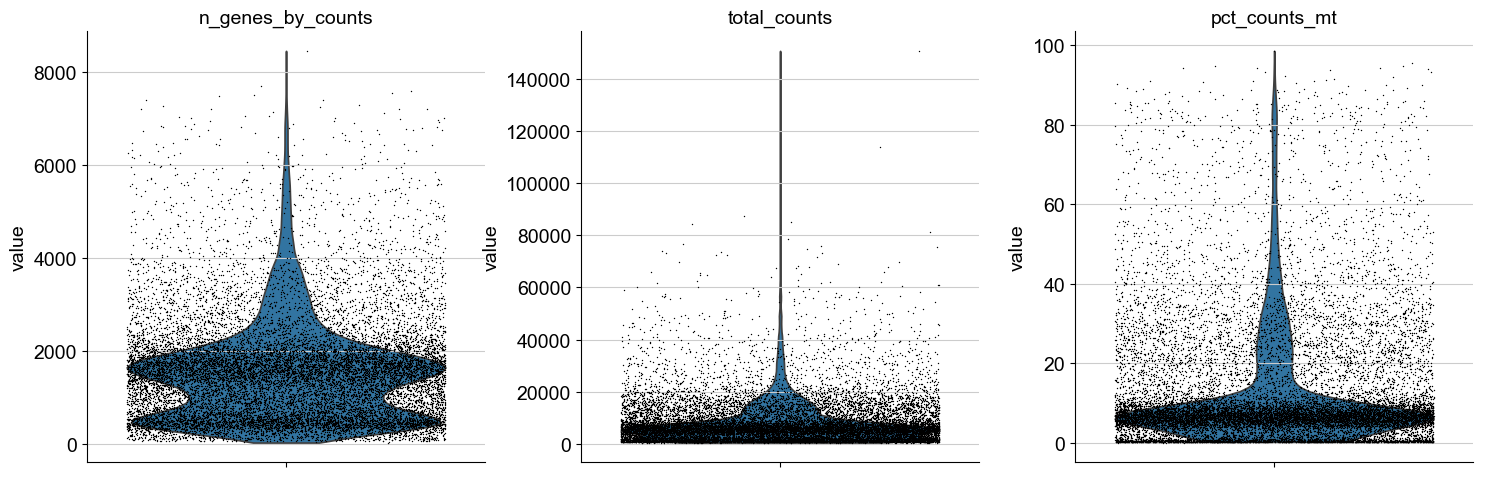

In [8]:
# PLOT - violin plot of QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter = 0.4,
    multi_panel = True,
)

Useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`

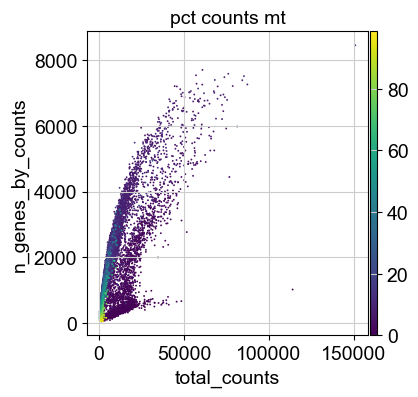

In [9]:
sc.pl.scatter(
    adata,
    'total_counts',
    'n_genes_by_counts',
    color = 'pct_counts_mt'
)

Then remove cells w/too many mito genes using thresholds

In [10]:
sc.pp.filter_cells(adata, min_genes = 100)
sc.pp.filter_genes(adata, min_cells = 3)

### DOUBLET DETECTION

- Doublets can lead to miscalculations/distortions downstream
- Scanpy uses Scrublet which uses NN to predict cell doublets
- `scanpy.pp.scrublet()` adds `doublet_score` and `predicted_doublet` to `.obs`

One can now either filter directly on predicted_doublet or use the doublet_score later during clustering to filter clusters with high doublet scores.

In [11]:
# Run scrublet for doublet detection
sc.pp.scrublet(
    adata,
    batch_key = 'sample'
)

### NORMALIZATION

Common approach is count depth scaling w/log plus one (log1p) transformation

- Count depth scaling normalizes the data to a "size factor" (such as median)
- Size factor controlled via `target_sum` in `pp.normalize_total`

In [12]:
# Saving count data
adata.layers['counters'] = adata.X.copy()

In [13]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

### FEATURE SELECTION

Reduce dimensionality and keep only the most informative genes

- `pp.highly_variable_genes` annotates highly variable genes by reproducing implementations of Seurat, Cell Ranger and Seurat based on your `flavor`

In [14]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes = 2000,
    batch_key = 'sample'
)

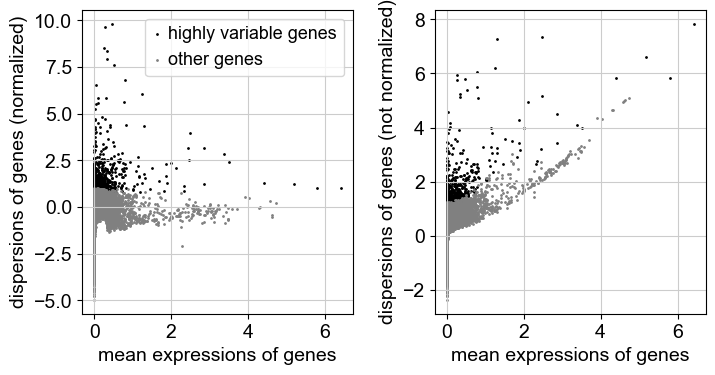

In [15]:
sc.pl.highly_variable_genes(adata)

### DIMENSIONALITY REDUCTION

Reduces the dimensions by running PCA

- reveals the main axes of variation
- denoises the data

In [16]:
sc.tl.pca(adata)

Inspect the contribution of single PCs to the total variance.

- gives us info about how many PCs we should consider in order to compute the neighborhood relations of cells used in the clustering function (ie. `leiden()` or `tsne()`)
- no major downsides to overestimating the # of PCs

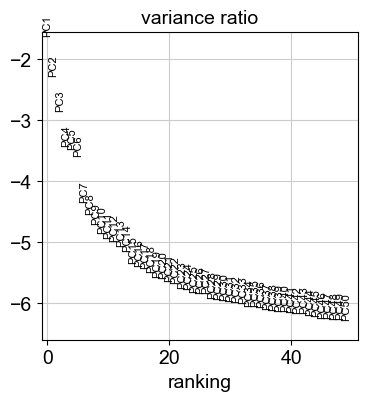

In [17]:
sc.pl.pca_variance_ratio(
    adata,
    n_pcs = 50, 
    log = True
)

You can also plot the PCs to see if any potentially undesired features (ie. batch, QC metrics) driving significant variation

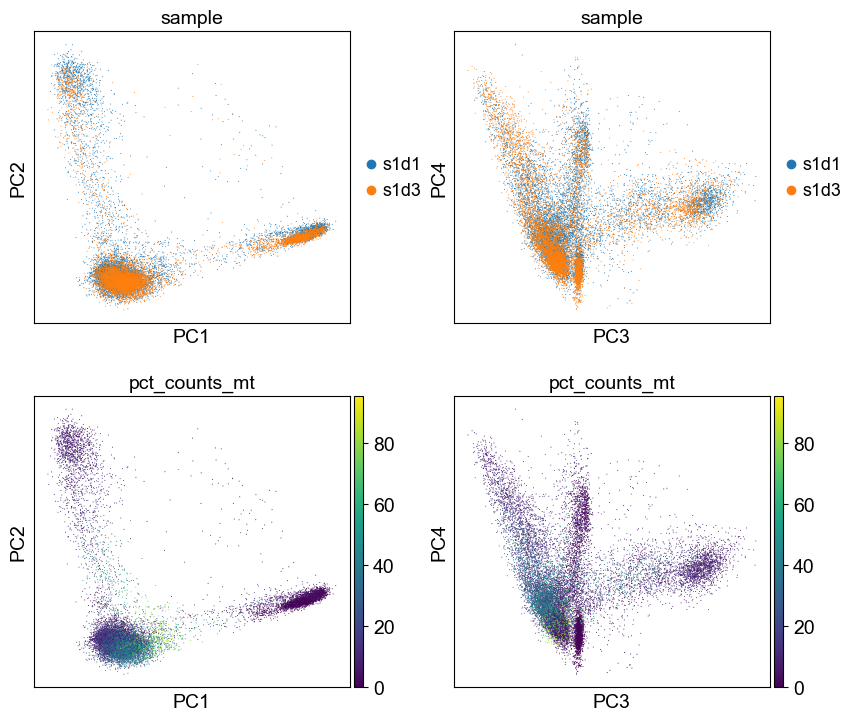

In [18]:
sc.pl.pca(
    adata,
    color = ["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions = [(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols = 2,
    size = 2,
)

### NN graph construction and viz

PCA representation of the data matrix

In [19]:
sc.pp.neighbors(adata)

Can be embedded in 2Ds for viz w/UMAP

In [20]:
sc.tl.umap(adata)

Viz the UMAP

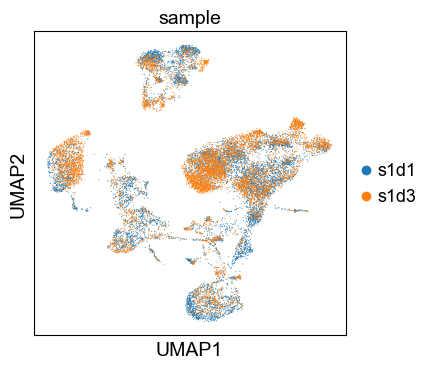

In [21]:
sc.pl.umap(
    adata,
    color = 'sample',
    size = 2 # smaller pts prevent overlap
)

2 diff samples in the data, minor batch effect, can continue w/clustering + annotation

BUT

If you see batch effects in your UMAP, it can be beneficial to integrate across samples and do batch correction/integration.

Recs: `scanorama` and `scvi-tools` for batch integration

### CLUSTERING

Like w/Seurat and other frameworks, they rec Leiden graph-clustering (community detection based on optimizing modularity).

NOTE: Leiden clustering directly clusters the neighborhood graph of cells which we already computed in the previous section

In [24]:
# Using igraph implementation and a fixed # of iterations can be much faster on large datasets
sc.tl.leiden(
    adata,
    flavor = 'igraph',
    n_iterations = 2
)

In [ ]:
sc.pl.umap(
    adata,
    color = ['leiden']
)

### RE-ASSESS QC + CELL FILTERING

By visualizing diff QC metrics using UMAP

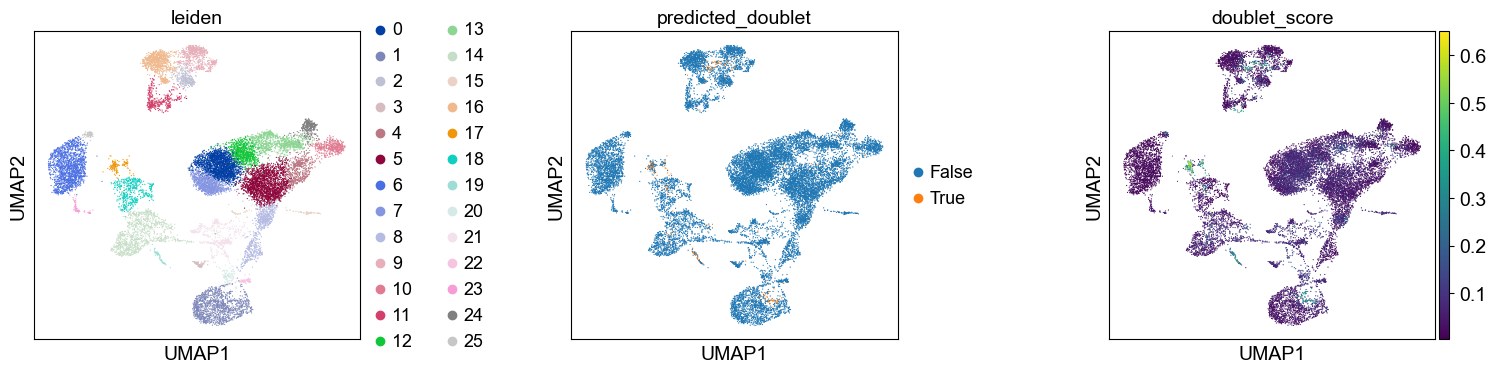

In [30]:
sc.pl.umap(
    adata,
    color = ['leiden', 'predicted_doublet', 'doublet_score'],
    wspace = 0.5, # increase horizontal space betw panels
    size = 3
)